In [20]:
import requests
import time
import json
import matplotlib.pyplot as plt

In [26]:

# Prometheus server URL
PROMETHEUS_URL = "http://127.0.0.1:9090"
# Prometheus query to fetch the metric in watts if greater than 0.01
QUERY = 'scaph_process_cpu_usage_percentage{container_scheduler="docker"} > 0.1'
SAVE_FILE_PATH_DATA = "/home/caterina/ee-5g/data/cpu-time-pods.json"
SAVE_FILE_PATH_PLOT = "figures/cpu-time-pods.png"


In [22]:
def fetch_metrics():
    """Fetches metrics from Prometheus and returns a dictionary of values by container ID."""
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query", params={'query': QUERY})
    metrics_by_container = {}

    if response.status_code == 200:
        try:
            result = response.json()
            for entry in result['data']['result']:
                # Extract container_id and metric value
                container_id = entry['metric'].get('container_id', 'unknown')
                value = float(entry['value'][1])
                cmdline= entry['metric'].get('cmdline', 'unknown')
                timestamp = time.time()

                # Initialize list if container_id not in dictionary
                if container_id not in metrics_by_container:
                    metrics_by_container[container_id] = []
                
                # Append timestamped metric
                metrics_by_container[container_id].append({'timestamp': timestamp, 'value': value, 'cmdline':cmdline})
                
            return metrics_by_container
        except (IndexError, KeyError):
            print("Error parsing metrics.")
            return {}
    else:
        print(f"Failed to fetch metrics. Status code: {response.status_code}")
        return {}

def collect_metrics(duration):
    """Collects metrics for the specified duration and saves them to a JSON file."""
    metrics_over_time = {}
    start_time = time.time()

    while time.time() - start_time < duration:
        metrics = fetch_metrics()
        for container_id, data_points in metrics.items():
            if container_id not in metrics_over_time:
                metrics_over_time[container_id] = []
            metrics_over_time[container_id].extend(data_points)
        time.sleep(0.5)  # Collect every half of second

    # Save metrics to JSON file
    with open(SAVE_FILE_PATH_DATA, "w") as f:
        json.dump(metrics_over_time, f)
    
    print(f"Metrics saved to '{SAVE_FILE_PATH_DATA}'")
    return metrics_over_time

In [23]:
def plot_metrics(file_path_data, save_file_path_plot, interval=2, cmdline_max_length=150):
    """Reads metrics from the JSON file, downsamples to the specified interval, and plots them."""
    # Load data from JSON file
    try:
        with open(file_path_data, "r") as f:
            metrics_over_time = json.load(f)
    except FileNotFoundError:
        print(f"{file_path_data} not found. Please collect metrics first.")
        return

    plt.figure(figsize=(20, 15))

    # Plot each container's data with a unique color
    for container_id, container_data in metrics_over_time.items():
        downsampled_data = []
        last_timestamp = None
        
        # Downsample the data to show points every `interval` seconds
        for entry in container_data:
            timestamp = entry['timestamp']
            value = entry['value']
            cmdline = entry['cmdline']
            
            # Truncate cmdline if it's too long --> for label purpose
            if len(cmdline) > cmdline_max_length:
                cmdline = cmdline[:cmdline_max_length] + '...'

            # Add the first data point or any data point at least `interval` seconds after the last
            if last_timestamp is None or (timestamp - last_timestamp) >= interval:
                downsampled_data.append((timestamp, value))
                last_timestamp = timestamp

        # Normalize timestamps to start from 0
        if downsampled_data:
            min_timestamp = downsampled_data[0][0]
            normalized_times = [(t[0] - min_timestamp) for t in downsampled_data]
            values = [t[1] for t in downsampled_data]
            
            # Plot the downsampled data for this container ID using cmdline in the label
            plt.plot(normalized_times, values, marker='o', linestyle='-', label=f"{container_id} -- {cmdline}")

    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU usage over time consumed by the process, as a percentage of the capacity of all the CPU Cores") 
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.40), ncol=1)  # Centered at bottom
    #plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(save_file_path_plot)
    print(f"Plot saved as {save_file_path_plot}")

Metrics saved to '/home/caterina/ee-5g/data/cpu-time-containers.json'
Plot saved as figures/cpu-time-containers.png


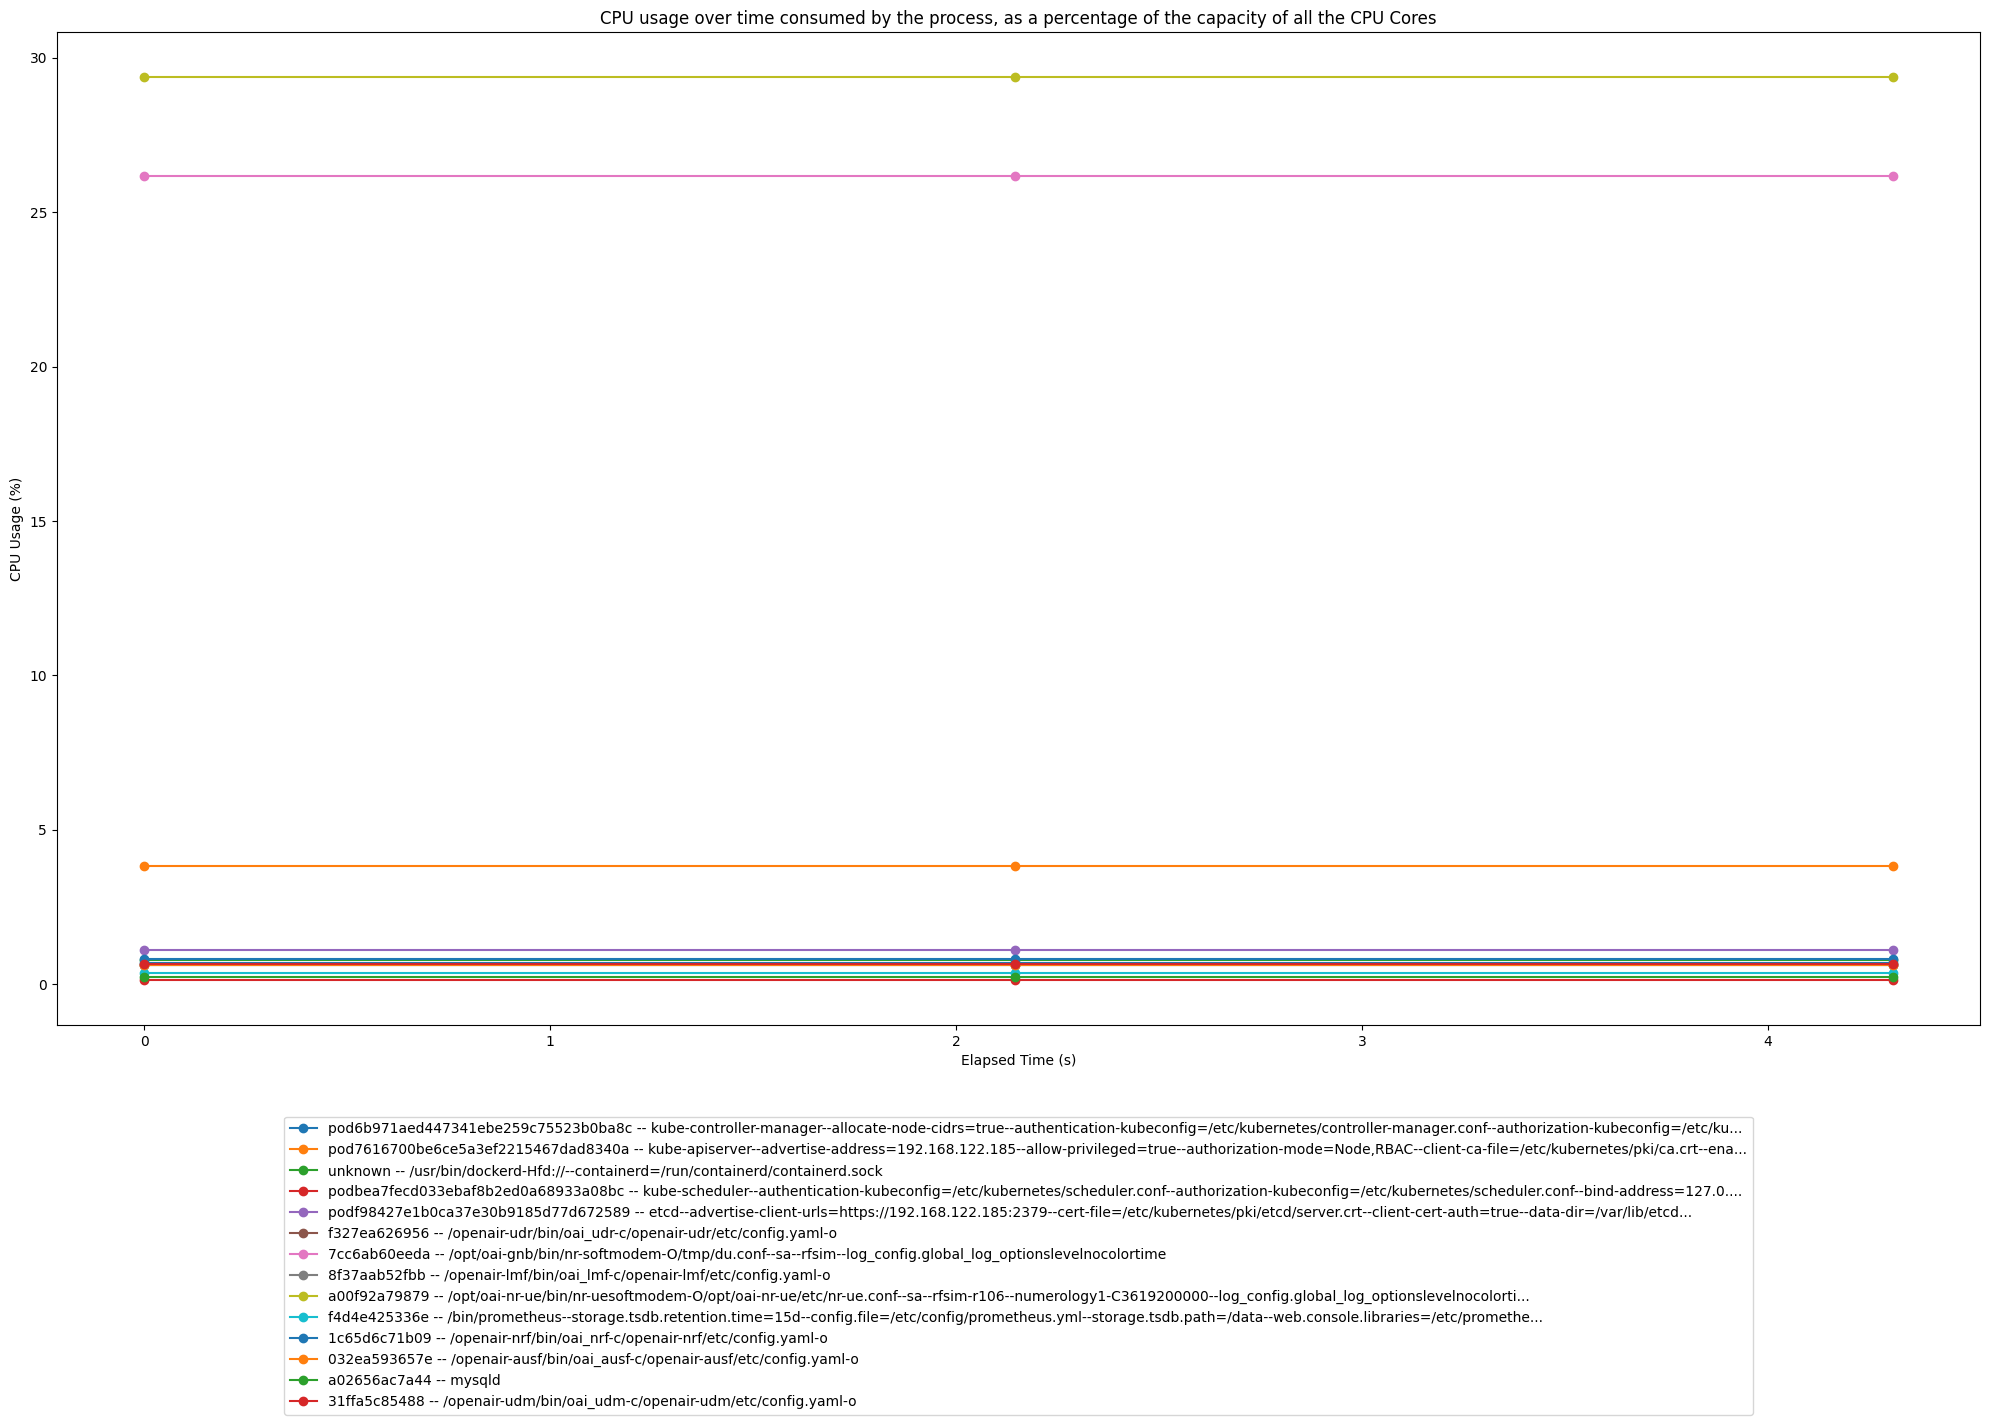

In [27]:
# Collect metrics and plot them
collect_metrics(duration=5)
plot_metrics(SAVE_FILE_PATH_DATA, SAVE_FILE_PATH_PLOT, interval=2)